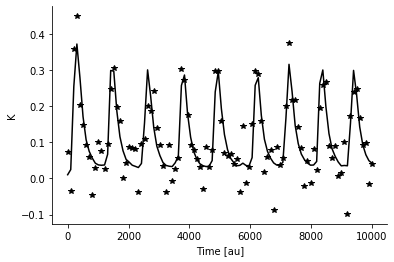

In [16]:
import pyabc
from study_abc_noise.model import HodgkinHuxleyModelVars as ModelVars
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import logging
import pickle
%matplotlib inline

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)

n_t = 100
# basedir must point to an installation of the model
mv = ModelVars(n_t=n_t, basedir='/home/icb/yannik.schaelte/Study-ABC-Noise/study_abc_noise/')
#mv = ModelVars(n_t=n_t, basedir="..", noise_std=0.05)
mv.limits = {'dc': (18, 25), 'membrane_dim': (5, 15)}

# model
model = mv.get_model()
model_noisy = mv.get_model_noisy()

prior = mv.get_prior()
distance = mv.get_distance()
kernel = mv.get_kernel()
acceptor = pyabc.StochasticAcceptor()
eps = pyabc.Temperature()

#sampler = pyabc.sampler.RedisEvalParallelSampler(host="icb-mona", port=8775, batch_size=10)
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=20)

# data
def get_data():
    try:
        data_nonoise, data = pickle.load(open(f"data_{n_t}.dat", 'rb'))
    except:
        data_nonoise = model(mv.p_true)
        data = mv.add_noise_to_data(data_nonoise)
        pickle.dump((data_nonoise, data), open(f"data_{n_t}.dat", 'wb'))
    return data_nonoise, data

data_nonoise, data = get_data()

fig, ax = plt.subplots()
ax.plot(data_nonoise['K'], '-', color='k')
ax.plot(data['K'], '*', color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_size_inches((6,4))
ax.set_xlabel("Time [au]")
ax.set_ylabel("K")

for fmt in ['svg', 'eps']:
    plt.savefig(f"data_{n_t}.{fmt}", format=fmt)

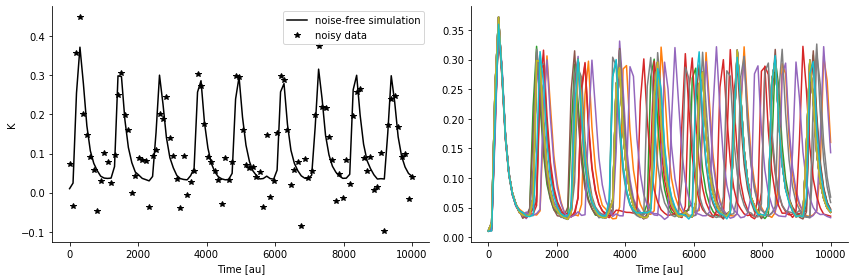

In [23]:
fig, arr_ax = plt.subplots(1,2)

ax = arr_ax[0]
ax.plot(data_nonoise['K'], '-', color='k', label="noise-free simulation")
ax.plot(data['K'], '*', color='k', label="noisy data")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Time [au]")
ax.set_ylabel("K")
ax.legend()

ax = arr_ax[1]
_model = ModelVars(n_t=n_t, basedir='..').get_model()
for _ in range(20):
    ax.plot(_model(mv.p_true)['K'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Time [au]")
ax.set_ylabel(None)

fig.set_size_inches((12,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"data_and_model_trajectories.{fmt}", format=fmt)

In [59]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000, sampler=sampler)
abc.new(f"sqlite:///h_incorrect_{n_t}.db", data)
abc.run(max_nr_populations=15, min_acceptance_rate=1e-4)

DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1
INFO:History:Start <ABCSMC(id=4, start_time=2020-01-26 22:19:01.216132, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.54519837138715
INFO:ABC:t: 0, eps: 1.54519837138715.
INFO:ABC:Acceptance rate: 1000 / 2130 = 4.6948e-01, ESS=1.0000e+03.
DEBUG:Epsilon:new eps, t=1, eps=1.3776968728059384
INFO:ABC:t: 1, eps: 1.3776968728059384.
INFO:ABC:Acceptance rate: 1000 / 3147 = 3.1776e-01, ESS=9.3076e+02.
DEBUG:Epsilon:new eps, t=2, eps=0.9430983371450585
INFO:ABC:t: 2, eps: 0.9430983371450585.
INFO:ABC:Acceptance rate: 1000 / 3186 = 3.1387e-01, ESS=9.4410e+02.
DEBUG:Epsilon:new eps, t=3, eps=0.5016710932027479
INFO:ABC:t: 3, eps: 0.5016710932027479.
INFO:ABC:Acceptance rate: 1000 / 2918 = 3.4270e-01, ESS=8.6504e+02.
DEBUG:Epsilon:new eps, t=4, eps=0.31282863650782194
INFO:ABC:t: 4, eps: 0.31282863650782194.
INFO:ABC:Acceptance rate: 1000 / 3839 = 2.6048e-01, ESS=9.82

In [61]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000)
abc.new(f"sqlite:///h_exact_{n_t}.db", data_nonoise)
abc.run(max_nr_populations=15, min_acceptance_rate=1e-4)

DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1
INFO:History:Start <ABCSMC(id=1, start_time=2020-01-26 22:46:47.292702, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.3236367845026262
INFO:ABC:t: 0, eps: 1.3236367845026262.
INFO:ABC:Acceptance rate: 1000 / 1993 = 5.0176e-01, ESS=1.0000e+03.
DEBUG:Epsilon:new eps, t=1, eps=1.1443316947203024
INFO:ABC:t: 1, eps: 1.1443316947203024.
INFO:ABC:Acceptance rate: 1000 / 3374 = 2.9638e-01, ESS=9.4518e+02.
DEBUG:Epsilon:new eps, t=2, eps=0.6694293533788362
INFO:ABC:t: 2, eps: 0.6694293533788362.
INFO:ABC:Acceptance rate: 1000 / 2975 = 3.3613e-01, ESS=9.0725e+02.
DEBUG:Epsilon:new eps, t=3, eps=0.31406021735809797
INFO:ABC:t: 3, eps: 0.31406021735809797.
INFO:ABC:Acceptance rate: 1000 / 3050 = 3.2787e-01, ESS=7.8565e+02.
DEBUG:Epsilon:new eps, t=4, eps=0.06301928142253423
INFO:ABC:t: 4, eps: 0.06301928142253423.
INFO:ABC:Acceptance rate: 1000 / 3830 = 2.6110e-01, ES

In [60]:
abc = pyabc.ABCSMC(model, prior, kernel, eps=eps, acceptor=acceptor, population_size=1000)
abc.new(f"sqlite:///h_stochacc_{n_t}.db", data)
abc.run()

INFO:History:Start <ABCSMC(id=1, start_time=2020-01-26 22:37:09.721852, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=1.5623e+02 for t=0.
DEBUG:Epsilon:Proposed temperatures for 0: [190.94030096031847].
INFO:ABC:t: 0, eps: 190.94030096031847.
DEBUG:Acceptor:Encountered pd=1.5690e+02 > c=1.5623e+02, thus weight=1.0035e+00.
DEBUG:Acceptor:Encountered pd=1.5668e+02 > c=1.5623e+02, thus weight=1.0024e+00.
DEBUG:Acceptor:Encountered pd=1.5679e+02 > c=1.5623e+02, thus weight=1.0029e+00.
DEBUG:Acceptor:Encountered pd=1.5676e+02 > c=1.5623e+02, thus weight=1.0028e+00.
DEBUG:Acceptor:Encountered pd=1.5644e+02 > c=1.5623e+02, thus weight=1.0011e+00.
DEBUG:Acceptor:Encountered pd=1.5643e+02 > c=1.5623e+02, thus weight=1.0010e+00.
INFO:ABC:Acceptance rate: 1000 / 3359 = 2.9771e-01, ESS=1.0000e+03.
DEBUG:Acceptor:pdf_norm=1.5690e+02 for t=1.
DEBUG:Epsilon:Proposed temperatures for 1: [160.89753212027264, 95.47015048015923].
INFO:ABC:t: 1, eps: 95.47015048015923.
IN

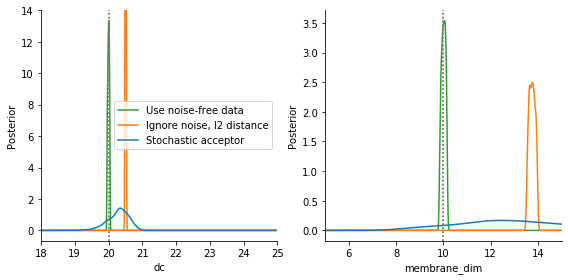

In [32]:
import pyabc
%matplotlib inline

def plot(h, x, ax, limits, p_true):
    for t in range(0, h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, t=t, x=x, xmin=limits[x][0], xmax=limits[x][1], ax=ax,
            refval=p_true, label=f"Iter. {t}")
    ax.legend()
    return ax

#h_exact = pyabc.History(f"sqlite:///h_incorrect_{noise_model}_exactdata.db")
h_incorrect = pyabc.History(f"sqlite:///h_incorrect_100.db")
h_exact = pyabc.History("sqlite:///h_exact_100.db")
h = pyabc.History(f"sqlite:///h_stochacc_100.db")

fig, arr_ax = plt.subplots(1,2)
for ip, p in enumerate(mv.p_true):
    ax = arr_ax[ip]
    for i, (h, label) in enumerate([(h_exact, "Use noise-free data"), (h_incorrect, "Ignore noise, l2 distance"), (h, "Stochastic acceptor")]):
        pyabc.visualization.plot_kde_1d_highlevel(h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], ax=ax,
                                                  refval=mv.p_true, refval_color='grey',
                                                  label=label, numx=500, color=f'C{2-i}')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
arr_ax[0].legend()
fig.set_size_inches((8,4))
fig.tight_layout()
for fmt in ['svg', 'eps']:
    plt.savefig(f"kde_1d.{fmt}", format=fmt)
    
#for p in mv.p_true:
#    _, ax = plt.subplots()
#    plot(h_incorrect, p, ax, mv.limits, mv.p_true)
#    _, ax = plt.subplots()
#    plot(h, p, ax, mv.limits, mv.p_true)
#    ax.legend()

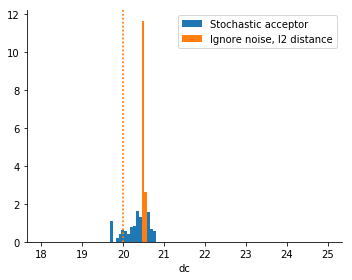

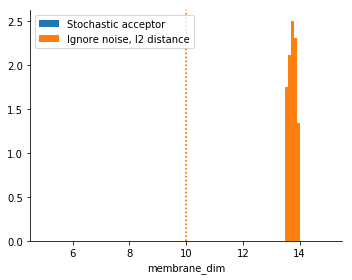

In [35]:
import pyabc
%matplotlib inline

def plot(h, x, ax, limits, p_true):
    for t in range(0, h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, t=t, x=x, xmin=limits[x][0], xmax=limits[x][1], ax=ax,
            refval=p_true, label=f"Iter. {t}")
    ax.legend()
    return ax

#h_exact = pyabc.History(f"sqlite:///h_incorrect_{noise_model}_exactdata.db")
h_incorrect = pyabc.History(f"sqlite:///h_incorrect_100.db")
h = pyabc.History(f"sqlite:///h_stochacc_100.db")

for p in mv.p_true:
    fig, ax = plt.subplots()
    for h, label in [(h, "Stochastic acceptor"), (h_incorrect, "Ignore noise, l2 distance")]:
        pyabc.visualization.plot_histogram_1d(h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], ax=ax,
                                         refval=mv.p_true, label=label, bins=100)
    ax.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.set_size_inches((5,4))
    fig.tight_layout()
    #ax.set_ylim(top=0.8)
    #for fmt in ['svg', 'eps']:
    #    plt.savefig(f"kde_1d_{p}_{noise_model}.{fmt}", format=fmt)
    
#for p in mv.p_true:
#    _, ax = plt.subplots()
#    plot(h_incorrect, p, ax, mv.limits, mv.p_true)
#    _, ax = plt.subplots()
#    plot(h, p, ax, mv.limits, mv.p_true)
#    ax.legend()

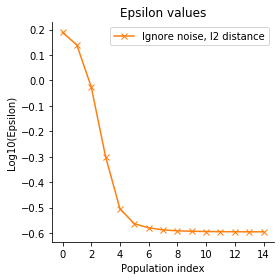

In [33]:
fig, ax = plt.subplots()
pyabc.visualization.plot_epsilons(h_incorrect, "Ignore noise, l2 distance", scale="log10", ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_lines()[-1].set_color('C1')
ax.legend()
fig.set_size_inches((4,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f'eps.{fmt}', format=f'{fmt}')
